<a href="https://colab.research.google.com/github/VMBoehm/ML_Lectures/blob/main/ImprovingVAEs_and_VAEs_on_imperfect_data_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Probabilistic denoising and inpainting of real data with VAEs**

by Vanessa Boehm (UC Berkeley and LBNL)   
Feb 27 2022

In this exercise session, we will start out by improving our VAE model with ome of the techniques we discussed in today's lecture.
In the second part we will use the improved VAE model to reconstruct corrupted data.

## **Part 1: Enhancing the VAE with a flow prior and $\mathbf{\beta}$-VAE**

In yesterday's exercise we saw how the VAE is struggling to simultaneousy minimize both the KL and the likelihood term in the ELBO. A low KL divergence is often associated with a lower reconstruction quality and a high reconstruction quality often comes at the cost of a higher KL-divergence and hence lower sample quality. 
We can improve on this situation with the help of a probabilistic model that we introduced in today's lecture: A normalizing flow. 

Recall that a normalizing flow is a non-linear bijective mapping, $z{=}h_\varphi(u)$, parameterized by $\varphi$, that has a computationally tractable Jacobian $\frac{\partial h_\varphi(u)}{\partial u}$. We can use this mapping to approximate a non-Gaussian probabiliy distribution $p(z)$,

$$ p(z) \approx \log p_\varphi(z)=\log \mathcal{p}_t(h^{-1}(z)) + \log \det \left[\frac{\partial h^{-1}_\varphi(z)}{\partial z}\right], \tag{1}$$

where $\mathcal{p}_t(h^{-1}(z))$ is some tractable distribution, typically a standard normal distribution.

Our vanilla VAE used a normal distribution as a prior. With the normalizing flow we can give the prior more flexibility.

$$ \mathrm{ELBO} = \int \mathrm{d}z\, q_\phi(z|x) \log{p_\psi(x|z)} - \int \mathrm{d}z\, q_\phi(z|x) \log{\frac{q_\phi(z|x)}{p_\varphi(z)}}, \tag{2}$$

Alternatively, we can change variables and write the ELBO in u-space (u becomes the new latent variable), where the prior remains Gaussian, but the encoder and decoder get complemented with the normalizing flow, 

$$f_\psi(z) \rightarrow f_\psi(h_\varphi(u))$$

$$g_\phi(z) \rightarrow g_\phi(h^{-1}_\varphi(u))$$

$$ \mathrm{ELBO} = \int \mathrm{d}u\,  q_\phi(h_\varphi^{-1}(u)|x)  \log{p_\psi(x|h_\varphi^{-1}(u))} - \int \mathrm{d}u\, q_\phi(h_\varphi^{-1}(u)|x) \log{\frac{q_\phi(h_\varphi^{-1}(u)|x)}{p_t(u)}}. \tag{3}$$

Both formulations are equivalent.
The normalizing flow makes it easier for the model to minimize both terms in the ELBO.

#### We start by defining our normalizing flow
I have implemented a realNVP. A realNVP is made of several layers. In each layer a subset of the variables is transformed with an affine transform and the remaining variables stay the same. This split makes the computation of the log determinant computationally tracable.

Assume we are in the first layer, $l=0$, and we have split the input data into $x = [x^{l=0}_{1:k}, x^{l=0}_{k:d}]$.  The transformation is,

$$ x^{l=1}_{1:k}= \exp(s(x^{l=0}_{k:d}))\cdot x^{l=0}_{1:k}  + t(x^{l=0}_{k:d})$$

$$ x^{l=1}_{k:d}= x^{l=0}_{k:d},$$

where $s$ and $t$ are neural networks.

Which variables we transform in each layer is a random choice (it could be a trainable parameter!).

You don't need to change anything in the RealNVP code below and you can use it as a black box, if you like.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torch

from torch.distributions import Normal as Normal
from torch.distributions import MultivariateNormal as MultivariateNormal 

### **RealNVP**

In [3]:
# One layer = a single RealNVP transform
class RealNVP_Transform(nn.Module):
    def __init__(self, binary_mask):
        """
        binary mask: boolean array of length LATENT_SIZE; the  binary mask determines which part of the data
        is transformed and which part stays the same
        """
        super().__init__()
        self.size         = len(binary_mask)
        self.mask         =  binary_mask[None,:].float()                  
        self.inverse_mask = (~binary_mask[None,:]).float()
        
        #registering the network parameters
        self.fc1_s        = torch.nn.Linear(self.size,self.size)
        self.fc2_s        = torch.nn.Linear(self.size,self.size)
        self.fc1_b        = torch.nn.Linear(self.size,self.size)
        self.fc2_b        = torch.nn.Linear(self.size,self.size)


    # network for computing s
    def network_s(self,x):
        x = self.fc1_s(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc2_s(x)
        x = torch.clip(x,-5,5)
        x = x*self.inverse_mask
        return x

    # network for computing t
    def network_t(self,x):
        x = self.fc1_b(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc1_b(x)
        x = x*self.inverse_mask
        return x

    # a forward pass (applies the affine trasnsform to one part of the data and leaves the other part immuted)
    def forward(self, u):
        masked_input = u*self.mask
        input        = u*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        z            = torch.exp(s)*input+t
        log_detJ     = torch.sum(s, axis=-1)
        z            = self.inverse_mask*z+masked_input
        return z, log_detJ

    # inverse of the forward pass
    def inverse(self,z):
        masked_input = z*self.mask
        input        = z*self.inverse_mask
        s            = self.network_s(masked_input)
        t            = self.network_t(masked_input)
        u            = (input-t)/torch.exp(s)
        log_detJ_inv = -torch.sum(s,axis=-1)
        u            = self.inverse_mask*u+masked_input
        return u, log_detJ_inv

# the full RealNVP Model
class FlowModel(nn.Module):
    def __init__(self, layers, dim):
        """
        layers: list of RealNVP_Transform instances; transformation layers
        dim   : int; dimensionality of the input data
        """
        super().__init__()
        self.dim      = dim
        self.layers   = nn.ModuleList(layers)
        self.depth    = len(self.layers)
        self.p_u      = MultivariateNormal(torch.zeros(self.dim), torch.eye(self.dim))

    # foward pass
    def forward(self,u):
        for ii, layer in enumerate(self.layers):
          if ii ==0:
            z, det = self.layers[ii].forward(u)
          else:
            z, det_ = self.layers[ii].forward(z)
            det+=det_
        return z, det

    #inverse pass
    def inverse(self,z):
        for ii in np.arange(self.depth-1,-1,-1):
          if ii ==(self.depth-1):
            u, inv_det = self.layers[ii].inverse(z)
          else:
            u, inv_det_ = self.layers[ii].inverse(u)
            inv_det+=inv_det_
        return u, inv_det

    # computes the log prob, using Eq. (1)
    def log_prob(self,z):
        shape        = z.shape
        z            = z.reshape(-1,self.dim)
        u, inv_det   = self.inverse(z)
        log_prob     = self.p_u.log_prob(u)
        log_prob+=inv_det
        return log_prob.reshape(shape[:-1])

    # sample from p(z) by transforming samples from p(u)
    def rsample(self, N_samples):
        u        = self.p_u.rsample(N_samples)
        z        = self.forward(u)[0]
        return z

#### Here's an example for how you would built a RealNVP:

In [4]:
# set number of layers and dimensionality of data
NLAYERS = 4
SIZE    = 4

# create random masks, we mask half of the data in each layer
if SIZE%2==0:
  mask    = np.append(np.zeros(SIZE//2),np.ones(SIZE//2))
else:
  mask    = np.append(np.zeros(SIZE//2+1),np.ones(SIZE//2))
masks= []
for ii in range(NLAYERS):
  np.random.shuffle(mask)
  masks.append(torch.as_tensor(mask).bool())
    
#initialize the layers
layers  = [RealNVP_Transform(masks[ii]) for ii in range(NLAYERS)]
#initialize the FlowModel
FM      = FlowModel(layers, SIZE)

# evaluate the log probability of same data
FM.log_prob(torch.as_tensor(np.random.randn(10,4)).float())

#test bijectivity
test = torch.ones((1,SIZE))
print(test)
print(FM.forward(FM.inverse(test)[0])[0])

tensor([[1., 1., 1., 1.]])
tensor([[1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<AddBackward0>)


With this we can go back to yesterday's VAE model (I just copy pasted the code below). Can you exchange the prior by a FlowPrior?
As before, I'll be giving you more detailed instructions in the code, marked by #TASK.

In [5]:
INPUT_SIZE      = 1000
# Yes, I have changed the latent size!
LATENT_SIZE     = 4

In [6]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize

In [8]:
class SDSS_DR16(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_train.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'DR16_denoised_inpainted_test.npy'),'rb'),allow_pickle=True)
        self.data = torch.as_tensor(self.data)
        self.mean = torch.mean(self.data)
        self.std  = torch.std(self.data)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.data[idx]-self.mean)/self.std

        return sample


training_data = SDSS_DR16(train=True)
test_data     = SDSS_DR16(train=False)

In [9]:
class VAEEncoder(nn.Module):

    def __init__(self, seed=853):
        super(VAEEncoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(INPUT_SIZE,50)
        self.fc2 = nn.Linear(50,LATENT_SIZE*2)

    def forward(self, x):
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = self.fc2(x)
        mu,std = torch.split(x, LATENT_SIZE,dim=-1)
        std    = torch.exp(std) + 1e-8
        return mu, std


In [10]:
class VAEDecoder(nn.Module):

    def __init__(self, seed=620):
        super(VAEDecoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(LATENT_SIZE,50)
        self.fc2 = nn.Linear(50,INPUT_SIZE)

    def forward(self, z):
        z = torch.nn.LeakyReLU()(self.fc1(z))
        x = self.fc2(z)
        return x

In [11]:
#TASK: Add a FlowModel as prior to the VAE, use 8 layers and set the random seed to 9303 before you create the masks
#HINT: Use this cell to initialize the model
NLAYERS = 8
SIZE    = LATENT_SIZE

# create random masks, we mask half of the data in each layer
if SIZE%2==0:
  mask    = np.append(np.zeros(SIZE//2),np.ones(SIZE//2))
else:
  mask    = np.append(np.zeros(SIZE//2+1),np.ones(SIZE//2))
masks= []
np.random.randint(9303)
for ii in range(NLAYERS):
  np.random.shuffle(mask)
  masks.append(torch.as_tensor(mask).bool())
  print(masks[-1])

#initialize the layers
layers  = [RealNVP_Transform(masks[ii]) for ii in range(NLAYERS)]

tensor([ True, False,  True, False])
tensor([ True,  True, False, False])
tensor([False, False,  True,  True])
tensor([False,  True, False,  True])
tensor([ True, False, False,  True])
tensor([ True, False,  True, False])
tensor([ True, False,  True, False])
tensor([False,  True, False,  True])


In [12]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, sample_size, sigma):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        self.sample_size = sample_size
        self.sigma       = sigma
        #TASK: insert new prior
        self.prior       = FlowModel(layers, LATENT_SIZE)

    def change_sample_size(self,sample_size):
        self.sample_size = sample_size
        return True

    def get_q(self,x):
        mu, std = self.encoder(x)
        self.q  = Normal(mu, std)
        return True

    def sample_q(self):
        z_sample = self.q.rsample(torch.Size([self.sample_size]))
        return z_sample

    def get_log_likelihood(self,recons,x):
        ll    = Normal(x[None,:,:], self.sigma)
        log_p = ll.log_prob(recons)
        log_p = torch.sum(log_p,dim=-1)
        return log_p

    def get_avg_log_likelihood(self,recons,x):
        log_p = self.get_log_likelihood(recons,x)
        return torch.mean(log_p,dim=0)

    def stochastic_kl_divergence(self,z_sample):
        #TASK: fix the shape error
        #HINT: the output shape of the FlowModel is different from the output shape of the prior we use previously, because the FlowModel uses a multivariate Gaussian as base ditribution
        return torch.mean(torch.sum(self.q.log_prob(z_sample),dim=-1)-self.prior.log_prob(z_sample), dim=0)

    def forward(self, x):
        self.get_q(x)
        samples = self.sample_q()
        recons  = self.decoder(samples)
        log_likelihood = self.get_avg_log_likelihood(recons,x)
        kl      = self.stochastic_kl_divergence(samples)
        return log_likelihood, kl

In [13]:
BATCHSIZE       = 128
BATCHSIZE_TEST  = 128
LEARNING_RATE   = 1e-3

#TASK: Initialize the VAE. Set sigma to 0.1 and sample size to 16
VAE       = VariationalAutoencoder(sample_size=16,sigma=0.1)

optimizer = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)


# Dataloaders
train_dataloader = DataLoader(training_data, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=BATCHSIZE_TEST, shuffle=True)

Let's check if the additional flow parameters were registered:

In [14]:
for name, param in VAE.named_parameters():
    if param.requires_grad:
        print(name)

encoder.fc1.weight
encoder.fc1.bias
encoder.fc2.weight
encoder.fc2.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
prior.layers.0.fc1_s.weight
prior.layers.0.fc1_s.bias
prior.layers.0.fc2_s.weight
prior.layers.0.fc2_s.bias
prior.layers.0.fc1_b.weight
prior.layers.0.fc1_b.bias
prior.layers.0.fc2_b.weight
prior.layers.0.fc2_b.bias
prior.layers.1.fc1_s.weight
prior.layers.1.fc1_s.bias
prior.layers.1.fc2_s.weight
prior.layers.1.fc2_s.bias
prior.layers.1.fc1_b.weight
prior.layers.1.fc1_b.bias
prior.layers.1.fc2_b.weight
prior.layers.1.fc2_b.bias
prior.layers.2.fc1_s.weight
prior.layers.2.fc1_s.bias
prior.layers.2.fc2_s.weight
prior.layers.2.fc2_s.bias
prior.layers.2.fc1_b.weight
prior.layers.2.fc1_b.bias
prior.layers.2.fc2_b.weight
prior.layers.2.fc2_b.bias
prior.layers.3.fc1_s.weight
prior.layers.3.fc1_s.bias
prior.layers.3.fc2_s.weight
prior.layers.3.fc2_s.bias
prior.layers.3.fc1_b.weight
prior.layers.3.fc1_b.bias
prior.layers.3.fc2_b.weight
prior.layers.3.fc2

In [15]:
def negative_ELBO(avg_log_likelihood,kl):

    negative_ELBO = - torch.mean(avg_log_likelihood-kl)

    return negative_ELBO

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh


In [17]:
#TASK: What do you observe in the training? How do the results compare to yesterday? 
#TASK: What happens when you change sigma?
#HINT: You don't need to plot all metrics, just look at the ELBO, likleihood and KL divergence on the test set and compare them to the numbers you observed yesterday
EPOCHS     = 10
train_loss = []
test_loss  = []
beta_init  = 100
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO))
print("Done!")

Epoch 1
-------------------------------
loss: 5075422.000000  [    0/100000]
loss: 66000433152.000000  [12800/100000]
loss: -301.648682  [25600/100000]
loss: -810.003967  [38400/100000]
loss: -1147.670044  [51200/100000]
loss: -945.245972  [64000/100000]
loss: -1146.257324  [76800/100000]
loss: -1067.301514  [89600/100000]
 Avg test loss      : 393.897183
 Avg KL             : 1402.956603
 Avg negative log likelihood : -1009.059191 

Epoch 2
-------------------------------
loss: -1127.936523  [    0/100000]
loss: 924.873535  [12800/100000]
loss: -1253.092285  [25600/100000]
loss: -593.872192  [38400/100000]
loss: -1173.064209  [51200/100000]
loss: -1169.584473  [64000/100000]
loss: -1249.810669  [76800/100000]
loss: -1286.231445  [89600/100000]
 Avg test loss      : -1161.517062
 Avg KL             : 18.048854
 Avg negative log likelihood : -1179.565916 

Epoch 3
-------------------------------
loss: -1275.282227  [    0/100000]
loss: -1058.309326  [12800/100000]
loss: -1068.678955  [2

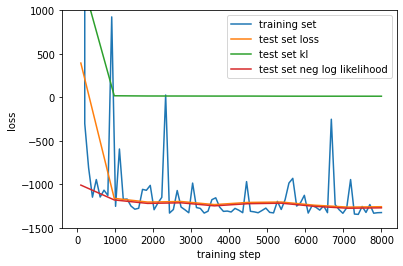

In [19]:
length = len(np.asarray(train_loss).flatten())
test_loss = np.asarray(test_loss)
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,0],label='test set loss')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,1],label='test set kl')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,2],label='test set neg log likelihood')
plt.xlabel('training step')
plt.ylabel('loss')
plt.ylim(-1500,1000)
plt.legend()
plt.show()

### **$\beta$-VAE**
Since the results are still not 100% satisfying, we will introduce another trick: artificial upweighting of the KL term.

In [ ]:
VAE       = VariationalAutoencoder(sample_size=16,sigma=0.1)

optimizer  = torch.optim.Adam(VAE.parameters(), lr=LEARNING_RATE)

In [ ]:
#TASK: add a parameter $\beta$, $\beta>=0$, to the ELBO.
#HINT: the default value should be 1
def negative_ELBO(avg_log_likelihood,kl, beta=1):

    negative_ELBO = - torch.mean(avg_log_likelihood-beta*kl)

    return negative_ELBO

In [ ]:
#TASK: add beta
def train_loop(dataloader, model, loss_fn, optimizer, beta):
    size = len(dataloader.dataset)
    losses = []
    for batch, X in enumerate(dataloader):
        log_likelihood, kl = model(X)
        loss = loss_fn(log_likelihood,kl,beta)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

#TASK: add beta
def test_loop(dataloader, model, loss_fn, beta):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, nllh, kl_ = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for X in dataloader:
            log_likelihood, kl = model(X)
            test_loss += loss_fn(log_likelihood,kl,beta).item()
            nllh += -np.mean(log_likelihood.cpu().numpy())
            kl_ += np.mean(kl.cpu().numpy())


    test_loss /= num_batches
    kl_ /= num_batches
    nllh /= num_batches

    print(f" Avg test loss      : {test_loss:>8f}")
    print(f" Avg KL             : {kl_:>8f}")
    print(f" Avg negative log likelihood : {nllh:>8f} \n")

    return test_loss, kl_, nllh


In [ ]:
#TASK: Train the beta-VAE with different values of beta. (Suggested: [10,100,500])
#TASK: try annealing beta during training
#TASK: which of these procedures works best? (look at all metrics:  1) recon error, 2) visual sample quality, 3) match between prior and average posterior, code is given below)
#HINT: beta must always be 1 during evaluation, otherwise we are not estimating an Evidence Lower BOund anymore!

EPOCHS = 10

train_loss = []
test_loss  = []
beta_init  = 100
for t in range(EPOCHS):
    beta = beta_init#max(beta_init*(EPOCHS-t),1)
    print('beta:', beta)
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, VAE, negative_ELBO, optimizer,beta))
    test_loss.append(test_loop(test_dataloader, VAE, negative_ELBO, beta=1))
print("Done!")

beta: 100
Epoch 1
-------------------------------
loss: 47923.906250  [    0/100000]
loss: -209.130203  [12800/100000]
loss: -294.618225  [25600/100000]
loss: -383.493896  [38400/100000]
loss: -730.978516  [51200/100000]
loss: -494.247070  [64000/100000]
loss: -717.127441  [76800/100000]
loss: -634.859558  [89600/100000]
 Avg test loss      : -949.389517
 Avg KL             : 4.390464
 Avg negative log likelihood : -953.779987 

beta: 100
Epoch 2
-------------------------------
loss: -688.338013  [    0/100000]
loss: 516.029541  [12800/100000]
loss: -809.499695  [25600/100000]
loss: -185.801788  [38400/100000]
loss: -652.549500  [51200/100000]
loss: -600.287903  [64000/100000]
loss: -726.572144  [76800/100000]
loss: -792.150513  [89600/100000]
 Avg test loss      : -1049.099909
 Avg KL             : 4.346346
 Avg negative log likelihood : -1053.446253 

beta: 100
Epoch 3
-------------------------------
loss: -772.932129  [    0/100000]
loss: -574.655273  [12800/100000]
loss: -527.52758

In [ ]:
#Optional: save weights
#torch.save(VAE.state_dict(), 'drive/MyDrive/ML_lecture_models/ImprovedVAE_model_weights_beta100.pth')

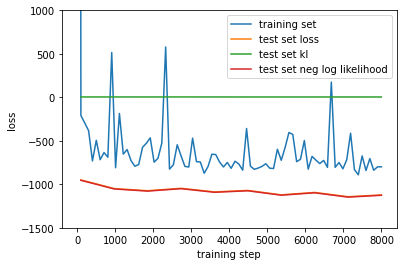

In [ ]:
test_loss=np.asarray(test_loss)
length = len(np.asarray(train_loss).flatten())
plt.figure()
plt.plot(np.linspace(0,length*100,length), np.asarray(train_loss).flatten(),label='training set')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,0],label='test set loss')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,1],label='test set kl')
plt.plot(np.linspace(100,(length)*100,len(test_loss)),test_loss[:,2],label='test set neg log likelihood')
plt.xlabel('training step')
plt.ylabel('loss')
plt.ylim(-1500,1000)
plt.legend()
plt.show()

In [ ]:
#TASK: compare this recon error to what you plotted for the vanilla VAE yesterday
wlmin, wlmax      = (3388,8318)
fixed_num_bins    = 1000
wl_range          = (np.log10(wlmin),np.log10(wlmax))
wl                = np.logspace(wl_range[0],wl_range[1],fixed_num_bins) 
 
avg_loss  = 0
VAE.eval()
with torch.no_grad():
    for X in test_dataloader:
        pred = VAE.decoder(VAE.encoder(X)[0])
        avg_loss+=np.mean((pred.cpu().numpy()-X.cpu().numpy())**2,axis=0)/(len(test_data)//BATCHSIZE_TEST)

plt.figure()
plt.plot(wl, np.sqrt(avg_loss))
plt.ylabel('average reconstruction error')
plt.xlabel('wavelength [Ångströms]')
plt.show()

(30000, 4)
(30080, 4)


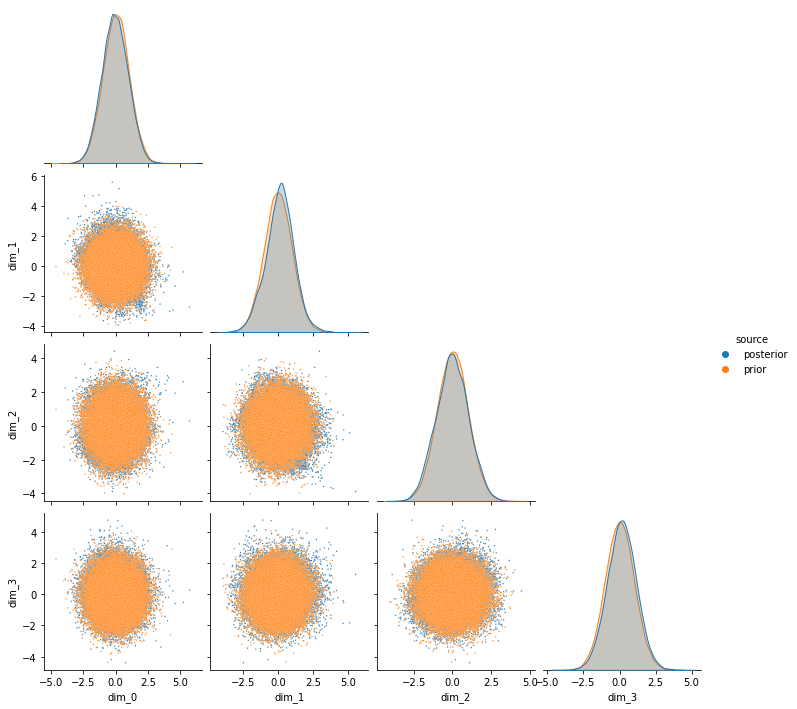

In [ ]:
#TASK: make a corner plot of posterior samples. Does the average posterior match the prior?
#TASK (optional): Can you change the code to compare the samples in u-space? (Both prior and posterior should be Gaussian in that space)

import seaborn as sns
import pandas as pd

VAE.eval()
with torch.no_grad():
    for ii, X in enumerate(test_dataloader):
        VAE.get_q(X)
        prior_sample = VAE.prior.p_u.rsample([BATCHSIZE_TEST]).cpu().numpy()
        sample       = VAE.prior.inverse(VAE.sample_q()[0])[0].cpu().numpy()
        if ii==0:
          samples       = sample
          prior_samples = prior_sample
        else:
          samples       = np.vstack([samples, sample])
          prior_samples = np.vstack([prior_samples, prior_sample])

samples       = np.reshape(samples,[-1, LATENT_SIZE])
prior_samples = np.reshape(prior_samples,[-1, LATENT_SIZE])

print(samples.shape)
print(prior_samples.shape)

data1    = pd.DataFrame()
data2    = pd.DataFrame()

for ii in range(LATENT_SIZE):
  data1['dim_%d'%ii] = samples[:,ii]
data1['source'] = 'posterior'

for ii in range(LATENT_SIZE):
  data2['dim_%d'%ii] = prior_samples[:,ii]
data2['source'] = 'prior'

data = pd.concat([data1,data2]).reset_index(drop=True)

sns.pairplot(data,corner=True,kind='scatter', hue='source', plot_kws={'s':2})
plt.show()

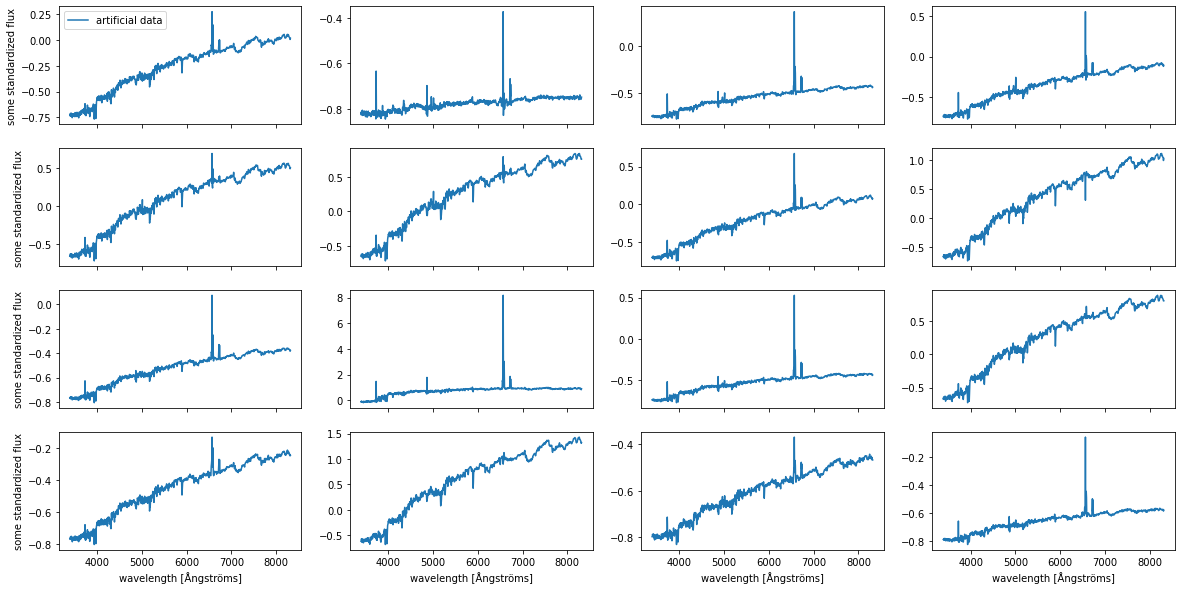

In [ ]:
# random samples
VAE.eval()
with torch.no_grad():
  samples      = VAE.prior.rsample([16])
  data_samples = VAE.decoder(samples)

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  ax[ii].plot(wl,data_samples[ii], label='artificial data')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

## **Part 1b: Testing the variational posterior**
How well does the variational posterior $q(z|x)$ approximate the real posterior $p(z|x)$? Let's have a look!
We can sample from $\log p(z|x)$ because we know $\log p(z|x)$ up to a constant:
$$\log p(z|x) = \log p(x|z)+ \log p(z)- const$$
Sampling becomes difficult in high dimensions, but since we have reduced the dimensionality to 4, we can try and sample the distribution with a simple Metropolis-Hastings Algorithm.

You don't need to know how a Metropolis-Hastings algorithm works for this exercise, I'll provide code below. But it's worth pointing out that the algorithm only uses ratios between probabilities of different points, which means that constants cancel out.

You can work with the model you trained above or you can use pretrained weights.

To load the pre-trained weights, you need to first [download them](https://drive.google.com/file/d/1KPle5I2q177uO5a-wF-yM_LUSN7cxpdf/view?usp=sharing) and put them in your Google Drive folder. Then uncomment the next two lines.

In [ ]:
#VAE.load_state_dict(torch.load('drive/MyDrive/ML_lecture_models/ImprovedVAE_model_weights_beta100.pth'))
#VAE.eval()

VariationalAutoencoder(
  (encoder): VAEEncoder(
    (fc1): Linear(in_features=1000, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=8, bias=True)
  )
  (decoder): VAEDecoder(
    (fc1): Linear(in_features=4, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=1000, bias=True)
  )
  (prior): FlowModel(
    (layers): ModuleList(
      (0): RealNVP_Transform(
        (fc1_s): Linear(in_features=4, out_features=4, bias=True)
        (fc2_s): Linear(in_features=4, out_features=4, bias=True)
        (fc1_b): Linear(in_features=4, out_features=4, bias=True)
        (fc2_b): Linear(in_features=4, out_features=4, bias=True)
      )
      (1): RealNVP_Transform(
        (fc1_s): Linear(in_features=4, out_features=4, bias=True)
        (fc2_s): Linear(in_features=4, out_features=4, bias=True)
        (fc1_b): Linear(in_features=4, out_features=4, bias=True)
        (fc2_b): Linear(in_features=4, out_features=4, bias=True)
      )
      (2): RealN

### Metropolis-Hastings Algorithm

In [ ]:
# This is a Metropolis Hastings algorithm. 
class MetropolisHastings():
    def __init__(self,dist,dim,std,mu,init,burn_in=1000):
        
        self.dim = dim
        self.std = std
        self.mu  = mu
        self.current_state = init
        self.dist          = dist
        self.current_log_prob = dist(init)
        self.burn_in       = burn_in

        
    def suggest_step(self):
        step = np.random.randn(self.dim)
        step = self.std*step+self.mu
        return step.astype(np.float32)
    
    def update_state(self):
        candidate = self.current_state+self.suggest_step()
        cand_log_prob = self.dist(candidate)
        ratio     = np.exp(cand_log_prob-self.current_log_prob)
        A         = min(ratio,1)
        dice      = np.random.rand()
        accepted  = 0
        if dice<= A:
            self.current_state = candidate
            self.current_log_prob = cand_log_prob
            accepted = 1
        return self.current_state, self.current_log_prob, accepted
    
    def sample(self,N_samples):
        ii = 0
        samples   = []
        log_probs = []
        accepted  = 0
        while ii<=N_samples+self.burn_in:
            sample, log_prob,acc = self.update_state()
            if torch.is_tensor(sample):
              sample=np.squeeze(sample.cpu().numpy())
            if ii>self.burn_in:
              samples.append(sample)
              log_probs.append(log_prob)
              accepted+=acc
            ii+=1
        return np.asarray(samples), np.asarray(log_probs), accepted/N_samples

:Here's an example for how to use the sampling alorithm. 
I use a multivariate Gaussian as target dsitribution here. We can sample from this distribution without a sampling alorithm and his allows us to evaluate the perfromance of the sampler.

0.825


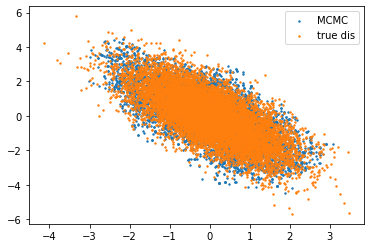

In [ ]:
from scipy.stats import multivariate_normal

# To initialize the sampler, we need to pass the function that evaluates the log probability of the distribution
dist = multivariate_normal(mean=np.asarray([0,0]), cov=np.asarray([[1,-1],[-1,2]]))
# the dimenionality of the problem,
dim  = 2
# the mean and standard deviation of the proposal distribution
std  = np.asarray([0.3,0.3])
mu   = np.asarray([0.0,0.0])
# and the starting point
init = np.asarray([0.,0.])

MH = MetropolisHastings(dist.logpdf,dim,std,mu,init)

#draw 100000 samples
samples, log_probs, acc_ratio = MH.sample(10000)
#The acceptance ratio should be between 0.6 and 0.8. 
#Too high could mean that parts of the distribution remain unsampled.
#Too low means your sampler is not efficienly exploring
#You can change the acc_ratio by changing the std of the proposal distribution
print(acc_ratio)

#draw correct samples from the dsitribution
real_samples       = dist.rvs(size=10000)

#compare
plt.scatter(samples[:,0],samples[:,1], s=2, label='MCMC')
plt.scatter(real_samples[:,0],real_samples[:,1], s=2, label='true dis')
plt.legend()
plt.show()

Let's sample from the variational posterior for a data point x.

In [ ]:
#TASK: write a function that returns a function that returns log p(z,x). 
def get_log_joint_prob(VAE, x):
    def log_joint_prob(z):
        recon = VAE.decoder(z)
        llh   = VAE.get_log_likelihood(recon,x)
        lpz   = VAE.prior.log_prob(z)
        return llh+lpz
    return log_joint_prob


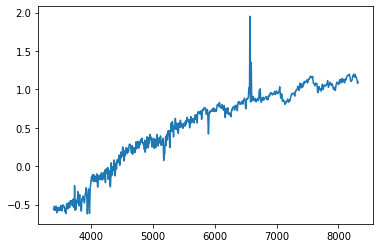

In [ ]:
# draw a data sample
x = iter(test_dataloader).next()
x = x[0:1]

plt.plot(wl, np.squeeze(x))
plt.show()

acceptance ratio:  0.5782


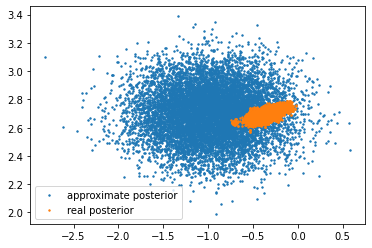

No handles with labels found to put in legend.


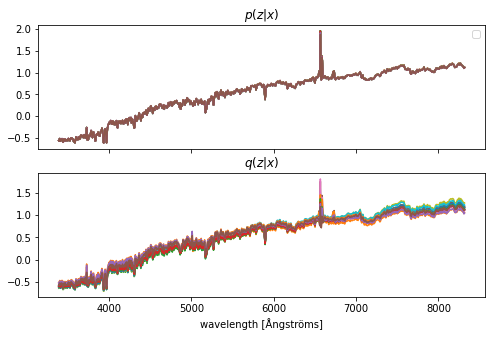

In [ ]:
#TASK: initiate a Metropolis-Hastings alorithm for sampling p(z,x)
#TASK: draw samples from p(z|x) for the nth entry in the test set
#HINT: you might need to adapt the std in order to achieve a good acceptance ratio
#HINT: use the encoded value as the starting point, if you see a "burn in", try different starting values

with torch.no_grad():
  log_prob = lambda y: get_log_joint_prob(VAE, x)(y).item()
  mu, std  = VAE.encoder(x)
  MH       = MetropolisHastings(log_prob,dim=LATENT_SIZE,std=np.ones(LATENT_SIZE,dtype=np.float32)*0.02,mu=np.zeros(LATENT_SIZE, dtype=np.float32),init=np.squeeze(mu))

  MCMC_samples, _, acceptance_ratio = MH.sample(10000)

print('acceptance ratio: ',acceptance_ratio)

#TASK: draw samples from the variational posterior
approx_posterior_samples  = std*np.random.randn(10000,LATENT_SIZE)+mu


#TASK: plot. What do you find?
plt.scatter(approx_posterior_samples[:,0],approx_posterior_samples[:,1], s=2, label='approximate posterior')
plt.scatter(MCMC_samples[:,0],MCMC_samples[:,1], s=2, label='real posterior')
plt.legend()
plt.show()

#TASK: Plot some of the samples in data space. Do you see a difference between the MCMC samples and the variational inference samples?
with torch.no_grad():
  post_samples = VAE.decoder(torch.as_tensor(MCMC_samples[:16]).float())
  q_samples = VAE.decoder(torch.as_tensor(approx_posterior_samples[:16]).float())


fig, ax = plt.subplots(2,1, figsize=(8,5), sharex=True)
ax = ax.flatten()
for ii in range(16):
    ax[0].plot(wl,post_samples[ii])
    ax[1].plot(wl,q_samples[ii])
ax[0].set_title(r'$p(z|x)$')
ax[1].set_title(r'$q(z|x)$')
ax[1].set_xlabel('wavelength [Ångströms]')
ax[0].legend()
plt.show()


### Take-away message: The variational posterior can be a bad approximation! It is generally not recommended to use it for scientific data analysis! 
You can use sampling algorithms on p(z,x) or other techniques for a more reliable posterior analysis.
Some sampling algorithms use derivatives to explore high dimensional spaces more efficiently (e.g. HMC). They can still perform reasonably well in situations where other alorithms struggle. With pytorch we can take derivative wrt to model inputs, as we will see below. 

## **Part 2: Reconstructing corrupted data**
We will now use some of the techniques we introduced above to denoise and inpaint noisy and masked data. 

Corrupted data, $\tilde {x}$ is related to uncorrupted data, $x$, through:

$$ \tilde{x} = M x + n, \tag{4}$$

where $M$ is the mask and $n$ is the noise.

For Gaussian noise with covariance $N$, we saw yesterday that this implies a Gaussian likelihood

$$ p(\tilde{x}|x) = \mathcal{G}(\tilde{x}|x,N) \tag{5}$$

For reconstruction we are interested in the posterior 

$$ p(x|\tilde{x}) \sim p(x,\tilde{x}) = p(x|\tilde{x}) p(x) \tag{6}$$

There are two problems with Eq.(6)

1. The posterior is extremely high dimensional (and sampling or analysing it basically impossible)
2. We don't know $p(x)$

We can solve both of these problems with the help of our VAE model. Our VAE model provides a mapping from the high dimensional data space, $x$, to a low dimensional space $z$. This mapping was trained to minimize the reconstruction error, i.e. we do not loose much information about $x$ by going to $z$. Also, we have access to the prior distribution $p(z)$. With these two ingredients, our forward model can be written as

$$ \tilde{x} = M g(z) + n, \tag{7}$$

where $g$ is the VAE decoder.

The likelihood becomes

$$ p(\tilde{x}|z) = \mathcal{G(\tilde{x}|g(z),N)}.$$

(If the reconstruction error of the VAE is not neligible compared to the noise, the two can be added quadratically).

And finally, we can write the posterior in the lower dimensional latent space

$$ p(z|\tilde{x}) \sim p(z,\tilde{x}) = p(z|\tilde{x}) p(z), \tag{8}$$

with the VAE prior $p(z)$.

This posterior is low dimensional and we can sample from it or find its maximum (the most likely reconstruction).

Let's start by importing some *real* data.
The data files can be found [here](https://drive.google.com/file/d/1D2dcGbCgVuOCU1fpPP5S33mTW2BAFRkX/view?usp=sharing) and should be placed in your google drive.

The Dataset method $__getitem__$ now returns a dictionary. The dictionary entries are data['spec'], which is the noisy and masked data, data['mask'] and data['noise'], which are the mask and inverse noise variance, respectively.

In [ ]:
class SDSS_DR16_corrupted(Dataset):
    """De-redshifted and downsampled spectra from SDSS-BOSS DR16, this time with noise and everything"""

    def __init__(self, root_dir='drive/MyDrive/ML_lecture_data/', transform=True, train=True):
        """
        Args:
            root_dir (string): Directory of data file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        if train:
            self.data = np.load(open(os.path.join(root_dir,'DR16_train.npy'),'rb'),allow_pickle=True)
        else:
            self.data = np.load(open(os.path.join(root_dir,'DR16_test.npy'),'rb'),allow_pickle=True)
        self.spec = torch.as_tensor(self.data['spec'])
        self.mask = torch.as_tensor(self.data['mask'])
        self.noise= torch.as_tensor(self.data['noise'])
        self.mean = torch.mean(self.spec)
        self.std  = torch.std(self.spec)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {}
        sample['spec']  = np.squeeze((self.spec[idx]-self.mean)/self.std).float()
        sample['noise'] = np.squeeze(self.noise[idx]*self.std**2).float()
        sample['mask']  = np.squeeze(self.mask[idx]).float()
        
        return sample


test_corrupted = SDSS_DR16_corrupted(train=False)

test_corrupted_loader  = DataLoader(test_corrupted, batch_size=1, shuffle=True)

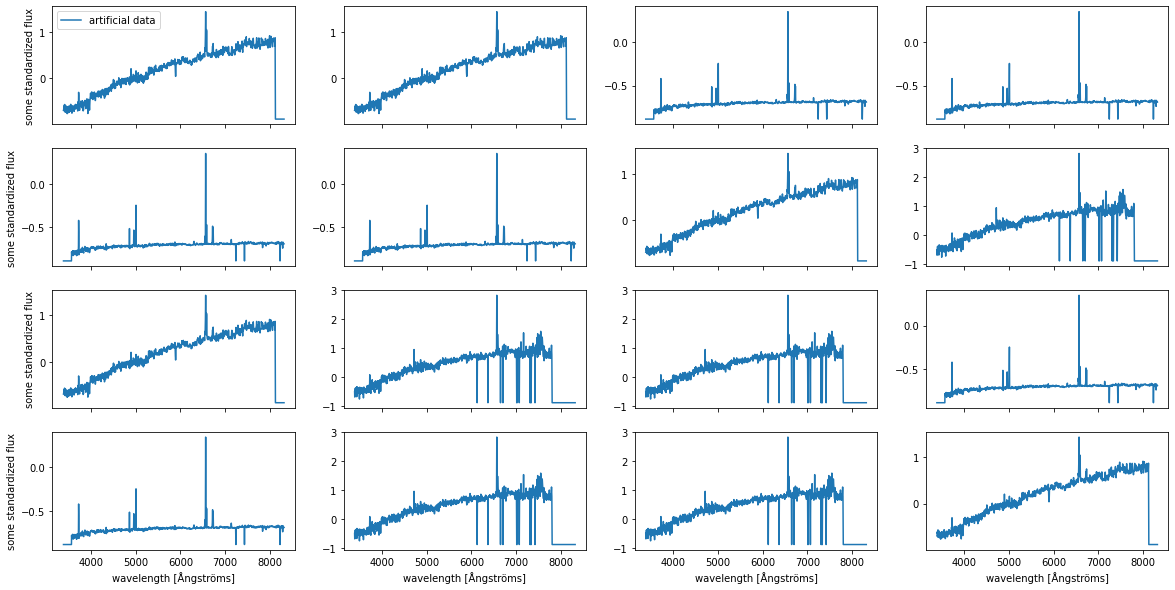

In [ ]:
#TASK: plot some data samples. Observe how they are noisy? The masked parts have value 0.

fig, ax = plt.subplots(4,4, figsize=(20,10), sharex=True)
ax = ax.flatten()
for ii in range(16):
  data_sample = np.squeeze(next(iter(test_corrupted_loader))['spec'])
  ax[ii].plot(wl,data_sample, label='artificial data')
  if ii in np.arange(12,16):
    ax[ii].set_xlabel('wavelength [Ångströms]')
  if ii in [0,4,8,12]:
    ax[ii].set_ylabel('some standardized flux')
  if ii==0:
    ax[ii].legend()
plt.show()

In [ ]:
#TASK: write a function that computes the lo likleihood of corrupted data p(\tilde(x)|z)
def corrupted_log_likelihood(x,recon,mask,noise):
    x     = torch.masked_select(x,mask)
    noise = torch.masked_select(noise,mask)
    recon = torch.masked_select(recon,mask)
    ll    = Normal(x, np.sqrt(1./noise))
    log_p = ll.log_prob(recon)
    log_p = torch.sum(log_p,dim=-1)
    return log_p

In [ ]:
#TASK: write a function that return a function that returns p(z,\tilde{x})
def get_corrupted_log_joint_prob(VAE, x, mask, noise):
    def corrupted_log_joint_prob(z):
        recon = VAE.decoder(z)
        llh   = corrupted_log_likelihood(recon,x,mask, noise)
        lpz   = VAE.prior.log_prob(z)
        return llh+lpz
    return corrupted_log_joint_prob

### Find the most likely reconstruction

2530.0419921875
1828.2369384765625
1251.4208984375
799.2042236328125
453.3592834472656
180.79795837402344
-35.46396255493164
-218.2163543701172
-370.7021484375
-498.0012512207031
-599.8228759765625
-681.6735229492188
-748.9591064453125
-801.7085571289062
-842.8917236328125
-875.0145874023438
-900.177490234375
-920.090087890625
-936.1004638671875
-949.2377319335938
-960.25244140625
-969.678466796875
-977.882568359375
-985.1087646484375
-991.516845703125
-997.2108154296875
-1002.2625732421875
-1009.2193603515625
-1015.5632934570312
-1021.0707397460938


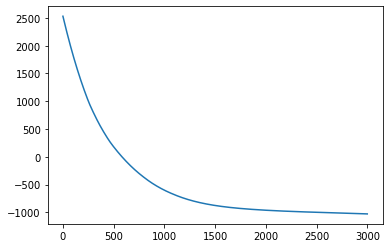

In [ ]:
#TASK: Start from the encoded value f(\tilde(x)) and maximize p(z,\tilde(x)) wrt to z

#turn off gradients wrt neural network parameters
for param in VAE.parameters():
  param.requires_grad=False

data_sample = next(iter(test_corrupted_loader))
#TASK: Load a data sample
x           = data_sample['spec']
#TASK: get initial value
z_init      = VAE.encoder(x)[0]

corrupted_log_joint_prob = get_corrupted_log_joint_prob(VAE, x, data_sample['mask'].bool(), data_sample['noise'])

#Tell torch to track he input. This allows us to take the derivative wrt to it
z           = torch.autograd.Variable(torch.as_tensor(z_init),requires_grad=True)

#
optim       = torch.optim.Adam([z],lr=1e-3)

losses      = []
for ii in range(3000):
    ll = -corrupted_log_joint_prob(z)
    optim.zero_grad()
    ll.backward()
    optim.step()
    if ii%100==0:
      print(ll.item())
    losses.append(ll.item())

plt.plot(losses)
plt.show()

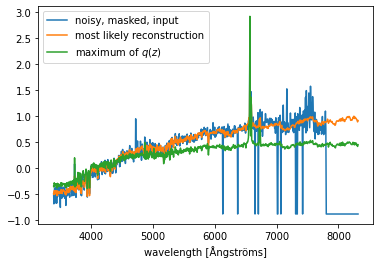

In [ ]:
#TASK: foward model the result into data space, compare to the foward modeled encoded value
plt.plot(wl,np.squeeze(x), label='noisy, masked, input')
plt.plot(wl,np.squeeze(VAE.decoder(z).detach().cpu().numpy()),label='most likely reconstruction')
plt.plot(wl,np.squeeze(VAE.decoder(VAE.encoder(x)[0]).detach().cpu().numpy()),label='maximum of $q(z)$')
plt.xlabel('wavelength [Ångströms]')
plt.legend()
plt.show()

### Posterior Samples

No handles with labels found to put in legend.


acceptance ratio:  0.7345


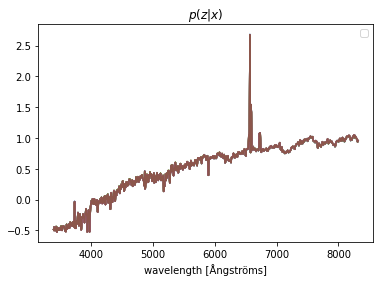

In [ ]:
#TASK: Use the metropolis hastings sampler to sample from the posterior for data sample ...
#TASK: foward model some of the samples -> by how much do they vary?

with torch.no_grad():
  log_prob = lambda y: corrupted_log_joint_prob(y).item()
  mu, _    = VAE.encoder(x)
  MH       = MetropolisHastings(log_prob,dim=LATENT_SIZE,std=np.ones(LATENT_SIZE,dtype=np.float32)*0.01,mu=np.zeros(LATENT_SIZE, dtype=np.float32),init=np.squeeze(z.detach()))

  MCMC_samples, _, acceptance_ratio = MH.sample(10000)

print('acceptance ratio: ',acceptance_ratio)

with torch.no_grad():
  post_samples = VAE.decoder(torch.as_tensor(MCMC_samples[:16]).float())


fig, ax = plt.subplots(1,1, figsize=(6,4), sharex=True)
for ii in range(16):
    ax.plot(wl,post_samples[ii])
ax.set_title(r'$p(z|x)$')
ax.set_xlabel('wavelength [Ångströms]')
ax.legend()
plt.show()
